# Compare absolute and geostrophic transport between transects

## Imports

In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
from geopy.distance import geodesic
import gsw
import dbdreader
import sys
from scipy import integrate
from scipy.constants import g
from matplotlib.colors import LogNorm


########################################################################################################
def load_glider_data(data_files, cac_dir):
    """
    Inspired by code in: https://github.com/truedichotomy/CTD_thermal_lag/
    
    Prepare data for analysis. Reads specific sensors into a dataframe and interpolates glider sensors onto science time.
    Assigns profile id to each value, removes invalid values, and converts units of specific variables.

    Args:
        data_files (string): Pathname to desired .EBD and .DBD files for a deployment
        cac_dir (string): Pathname to directory housing associated cache files for a deployment

    Returns:
        Pandas dataframe (group) with glider data
    """
    ## Initialize dbd class
    dbd = dbdreader.MultiDBD(pattern = data_files,
                             cacheDir=cac_dir)
    
    ## Since time stamp of flight and science parameters on CTD time stamp
    tctd, C, T, P, buoyancy_change, pitch, lat, lon, num_inflections,m_water_vx,m_water_vy,m_gps_mag_var = dbd.get_CTD_sync("m_de_oil_vol", "m_pitch","m_lat","m_lon","m_tot_num_inflections","m_water_vx","m_water_vy","m_gps_mag_var")
    ## num inflections is weird
    num_inflections = num_inflections.astype(int)

    
    ## Stuff data in a pandas dataframe
    d = {'ctd_time': tctd, 'conductivity': C, 'temperature':T, 'pressure':P, 'latitude':lat, 'longitude':lon, 'num_inflections':num_inflections, 'm_water_vx': m_water_vx, 'm_water_vy': m_water_vy, 'm_gps_mag_var': m_gps_mag_var}
    sci_data = pd.DataFrame(d)
    
    ## Now a lot of conversions
    ## Format time
    sci_data['time'] = pd.to_datetime(sci_data['ctd_time'], unit='s')
    ## Convert pressure to dbar
    sci_data['pressure'] = sci_data['pressure']*10
    ## Convert from pressure to depth
    sci_data['depth'] = -gsw.z_from_p(sci_data.pressure, sci_data.latitude)
    ## Convert to practical salinity
    sci_data['practical_salinity'] = gsw.SP_from_C(sci_data.conductivity*10, sci_data.temperature, sci_data.pressure) ## C in S/m, T is in-situ, P in dbar 
    ## Convert to absolute salinity
    sci_data['absolute_salinity'] = gsw.SA_from_SP(sci_data.practical_salinity, sci_data.pressure, sci_data.longitude, sci_data.latitude)
    ## Convert to potential temperature ref to 0 meters
    sci_data['potential_temperature'] = gsw.pt0_from_t(sci_data.absolute_salinity, sci_data.temperature, sci_data.pressure)
    ## Convert to conservative temperature
    sci_data['conservative_temperature'] = gsw.CT_from_t(sci_data.absolute_salinity, sci_data.temperature, sci_data.pressure)
    ## in situ density
    sci_data['rho'] = gsw.rho_t_exact(sci_data.absolute_salinity, sci_data.temperature, sci_data.pressure) ## T is in-situ
    ## potential density
    sci_data['sigma'] = gsw.sigma0(sci_data.absolute_salinity, sci_data.conservative_temperature)+1000
    
    ## Assign profiles ids based on m_tot_num_inflections
    ## Forward and backfill m_tot_num_inflections variable so every value has an associated correct inflection count 
    sci_data['num_inflections'].ffill(inplace=True)
    sci_data['num_inflections'].bfill(inplace=True)
    
    # Drop all invalid and duplicate ctd timestamps and invalid lat/lon values
    sci_data = sci_data[sci_data['ctd_time'].ne(pd.Timestamp('1970-01-01 00:00:00.00'))].dropna(subset=['ctd_time']) 
    sci_data = sci_data.drop_duplicates(subset=['ctd_time'])
    sci_data = sci_data[sci_data['latitude'].ne(0)].dropna(subset=['latitude']) ## .ne() not equal
    sci_data = sci_data[sci_data['longitude'].ne(0)].dropna(subset=['longitude'])
    sci_data = sci_data.dropna(subset=['pressure'])
    
    #Create profile_id column based on when the m_tot_num_inflections variable iterates
    sci_data['profile_id'] = sci_data.groupby('num_inflections').ngroup()
    sci_data = sci_data.sort_values(by='time')
    sci_data.reset_index(drop=True,inplace=True) #reset indices
    
    return sci_data



########################################################################################################
## New function for bin-averaging to make sure taking mid-lat and long for geostrophy calculation
def depth_bin_average(df, dz=5):
    """
    Function to bin-average data by depth and construct an xarray dataset dynamically.

    Parameters:
        df (pd.DataFrame): DataFrame with columns ['time', 'depth', 'latitude', 'longitude', ...]
        dz (int, optional): Depth bin size.

    Returns:
        xr.Dataset: Dataset with depth-binned profiles along the time axis.
    """

    ds = None  # Initialize an empty dataset

    df = df.reset_index(drop=True)

    # Define depth bins
    max_depth = df["depth"].max()
    depth_bins = np.arange(np.floor(0 / dz) * dz, np.ceil(max_depth / dz) * dz + dz, dz)
    depth_mids = depth_bins[:-1] + dz / 2  # Midpoint of bins
    
    for prof in df["profile_id"].unique():
        profile = df[df["profile_id"] == prof]

        # Dictionary to hold bin-averaged variables
        data_vars = {}

        # Bin-average each variable (excluding non-data columns)
        for var in profile.columns:
            if var in ["time", "latitude", "longitude", "depth", "profile_id","pressure",'num_inflections']:
                continue  # Skip non-data variables
            else:
                # Bin the data
                binned_means = np.array([
                    np.nanmean(profile[(profile["depth"] >= depth_bins[i]) & (profile["depth"] < depth_bins[i+1])][var])
                    for i in range(len(depth_bins) - 1)
                ])
                # Count number of non-nan in bins
                binned_counts = np.array([
                    np.count_nonzero(~np.isnan(profile[(profile["depth"] >= depth_bins[i]) & (profile["depth"] < depth_bins[i+1])][var]))
                    for i in range(len(depth_bins) - 1)
                ])
                
                # Handle cases where no data exists in a bin
                if np.isnan(binned_means).all():
                    data_vars[var+"_counts"] = (["depth"], np.repeat(np.nan,len(depth_mids)))
                    
                # Store in dictionary
                data_vars[var] = (["depth"], binned_means)
                data_vars[var+"_counts"] = (["depth"], binned_counts)        

                    
            prof_time = profile.time.iloc[len(profile.depth)//2]  # Use the time of the middle depth
            prof_lat = profile.latitude.iloc[len(profile.depth)//2]  # Use the latitude of the middle depth
            prof_lon = profile.longitude.iloc[len(profile.depth)//2]  # Use the longitude of the middle depth
            start_time = profile.time.iloc[0]  # Use the time of the first depth
            end_time = profile.time.iloc[-1]  # Use the time of the last depth
            start_lat = profile.latitude.iloc[0]  # Use the latitude of the first depth
            end_lat = profile.latitude.iloc[-1]  # Use the latitude of the last depth
            start_lon = profile.longitude.iloc[0]  # Use the longitude of the first depth
            end_lon = profile.longitude.iloc[-1]  # Use the longitude of the last depth
            mag_var = np.nanmean(profile.m_gps_mag_var)


            # Safe extraction of last non-NaN u and v
            if var in ['m_water_vx', 'm_water_vy']:
                last_u_index = profile['m_water_vx'].last_valid_index()
                last_v_index = profile['m_water_vy'].last_valid_index()

                if last_u_index is None or pd.isna(profile.loc[last_u_index, 'm_water_vx']):
                    prof_u = np.nan
                else:
                    prof_u = profile.loc[last_u_index, 'm_water_vx']

                if last_v_index is None or pd.isna(profile.loc[last_v_index, 'm_water_vy']):
                    prof_v = np.nan
                else:
                    prof_v = profile.loc[last_v_index, 'm_water_vy']

        # Create a dataset for this profile
        profile_ds = xr.Dataset(
            data_vars,
            coords={"depth": ("depth", depth_mids), "time": [pd.to_datetime(prof_time)]}
        )

        ## Manually add start/end time and lat/lon
        profile_ds['u'] = (['time'], [prof_u])
        profile_ds['v'] = (['time'], [prof_v])
        profile_ds['start_time'] = (['time'], [pd.to_datetime(start_time)])
        profile_ds['end_time'] = (['time'], [pd.to_datetime(end_time)])
        profile_ds['start_latitude'] = (['time'], [start_lat])
        profile_ds['end_latitude'] = (['time'], [end_lat])
        profile_ds['start_longitude'] = (['time'], [start_lon])
        profile_ds['end_longitude'] = (['time'], [end_lon])
        profile_ds['mag_var'] = (['time'], [mag_var])


        # Add latitude and longitude as coordinates (keeping them 1D for alignment)
        profile_ds = profile_ds.assign_coords(
            latitude=("time", [prof_lat]),
            longitude=("time", [prof_lon]),
        )

        # Merge into the master dataset
        if ds is None:
            ds = profile_ds  # First profile initializes the dataset
        else:
            ds = xr.concat([ds, profile_ds], dim="time")  # Append new profile along time axis

    ## make sure time is in correct format
    ds['time'] = pd.to_datetime(ds.time)
    # Sort the dataset by the 'time' coordinate
    ds = ds.sortby('time')
    ## Flip
    ds = ds.transpose()

    return ds








def calc_segment_transport(ds):
    segment_transport = np.empty(len(ds.time))
    segment_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.time)):
        segment_dist = geodesic((ds.start_lat[x],ds.start_lon[x]),(ds.end_lat[x],ds.end_lon[x])).meters
        segment_transport[x] = np.nansum(ds.u_grid[:,x]*segment_dist*dz)
    
    ds["segment_transport"] = (("time"), segment_transport)

    return ds




def calc_segment_geostrophic_transport(ds):
    segment_transport = np.empty(len(ds.time))
    segment_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.time)):
        segment_dist = geodesic((ds.start_latitude[x],ds.start_longitude[x]),(ds.end_latitude[x],ds.end_longitude[x])).meters
        segment_transport[x] = np.nansum(ds.geostrophic_velocity[:,x]*segment_dist*dz)
    
    ds["segment_transport"] = (("time"), segment_transport)

    return ds





def calc_segment_ageostrophic_transport(ds):
    segment_transport = np.empty(len(ds.time))
    segment_transport[:] = np.nan
    dz = np.diff(ds.depth)[0]

    for x in np.arange(0,len(ds.time)):
        segment_dist = geodesic((ds.start_latitude[x],ds.start_longitude[x]),(ds.end_latitude[x],ds.end_longitude[x])).meters
        segment_transport[x] = np.nansum(ds.ageostrophic_velocity[:,x]*segment_dist*dz)
    
    ds["segment_ageo_transport"] = (("time"), segment_transport)

    return ds


## Load glider CTD data

This takes ~40 minutes

In [2]:
data_files = "../data/logs/*.[DE]BD"
cac_dir = "../data/cache/"
gdf = load_glider_data(data_files, cac_dir)

glider = depth_bin_average(gdf,dz=2)
glider

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46424/2677065443.py:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sci_data['num_inflections'].ffill(inplace=True)
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46424/2677065443.py:67: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values alw

<xarray.Dataset> Size: 130MB
Dimensions:                          (time: 1351, depth: 499)
Coordinates:
  * depth                            (depth) float64 4kB 1.0 3.0 ... 995.0 997.0
  * time                             (time) datetime64[ns] 11kB 2024-04-19T14...
    latitude                         (time) float64 11kB 17.78 17.78 ... 17.85
    longitude                        (time) float64 11kB -67.06 ... -67.04
Data variables: (12/33)
    ctd_time                         (depth, time) float64 5MB 1.714e+09 ... nan
    ctd_time_counts                  (depth, time) int64 5MB 65 0 79 0 ... 0 0 0
    conductivity                     (depth, time) float64 5MB 5.855 nan ... nan
    conductivity_counts              (depth, time) int64 5MB 65 0 79 0 ... 0 0 0
    temperature                      (depth, time) float64 5MB 28.63 nan ... nan
    temperature_counts               (depth, time) int64 5MB 65 0 79 0 ... 0 0 0
    ...                               ...
    end_time                         (time) datetime64[ns] 11kB 2024-04-19T14...
    start_latitude                   (time) float64 11kB 17.78 17.78 ... 17.85
    end_latitude                     (time) float64 11kB 17.78 17.78 ... 17.85
    start_longitude                  (time) float64 11kB -67.06 ... -67.04
    end_longitude                    (time) float64 11kB -67.06 ... -67.04
    mag_var                          (time) float64 11kB 0.2164 ... 0.2164

## Save/Easy reload

In [22]:
glider.to_netcdf('../data/processed_nc/RU29_2024_depth_gridded_glider_4_geostrophy.nc')
glider = xr.open_dataset('../data/processed_nc/RU29_2024_depth_gridded_glider_4_geostrophy.nc')
glider


<xarray.Dataset> Size: 130MB
Dimensions:                          (depth: 499, time: 1351)
Coordinates:
  * depth                            (depth) float64 4kB 1.0 3.0 ... 995.0 997.0
  * time                             (time) datetime64[ns] 11kB 2024-04-19T14...
    latitude                         (time) float64 11kB ...
    longitude                        (time) float64 11kB ...
Data variables: (12/33)
    ctd_time                         (depth, time) float64 5MB ...
    ctd_time_counts                  (depth, time) int64 5MB ...
    conductivity                     (depth, time) float64 5MB ...
    conductivity_counts              (depth, time) int64 5MB ...
    temperature                      (depth, time) float64 5MB ...
    temperature_counts               (depth, time) int64 5MB ...
    ...                               ...
    end_time                         (time) datetime64[ns] 11kB ...
    start_latitude                   (time) float64 11kB ...
    end_latitude                     (time) float64 11kB ...
    start_longitude                  (time) float64 11kB ...
    end_longitude                    (time) float64 11kB ...
    mag_var                          (time) float64 11kB ...

## Adjust DAC based on m_gps_mag_var

In [23]:
glider['u'] = glider.u*np.cos(glider.mag_var) - glider.v*np.sin(glider.mag_var)
glider['v'] = glider.u*np.sin(glider.mag_var) + glider.v*np.cos(glider.mag_var)



## Load glider ADCP data

In [24]:
ad2cp = xr.open_dataset('../data/processed_nc/RU29_2024_Processed_AD2CP.nc')
ad2cp

<xarray.Dataset> Size: 813kB
Dimensions:     (depth: 100, time: 486)
Coordinates:
  * time        (time) datetime64[ns] 4kB 2024-04-19T14:50:04 ... 2024-06-30T...
  * depth       (depth) float64 800B 5.0 15.0 25.0 35.0 ... 975.0 985.0 995.0
Data variables:
    u_grid      (depth, time) float64 389kB ...
    v_grid      (depth, time) float64 389kB ...
    latitude    (time) float64 4kB ...
    longitude   (time) float64 4kB ...
    start_lat   (time) float64 4kB ...
    start_lon   (time) float64 4kB ...
    end_lat     (time) float64 4kB ...
    end_lon     (time) float64 4kB ...
    start_time  (time) datetime64[ns] 4kB ...
    end_time    (time) datetime64[ns] 4kB ...
Attributes:
    description:  RU29 Nortek AD2CP least-squares inversion velocity profile ...

## Subset to transects

In [25]:
## Taken from RU29_ABC2DR_Analysis.ipynb
transect1_start_time = pd.to_datetime('2024-04-27T20:05:00Z').tz_localize(None) ## transect 1 start time
transect1_end_time = pd.to_datetime('2024-05-18T12:00:00Z').tz_localize(None) ## transect 1 end time
transect2_start_time = pd.to_datetime('2024-05-19T00:00:00Z').tz_localize(None) ## transect 2 start time
transect2_end_time = pd.to_datetime('2024-06-06T00:00:00Z').tz_localize(None) ## transect 2 end time

transect1_ad2cp = ad2cp.sel(time=slice(transect1_start_time,transect1_end_time))
transect1_glider = glider.sel(time=slice(transect1_start_time,transect1_end_time))

transect2_ad2cp = ad2cp.sel(time=slice(transect2_start_time,transect2_end_time))
transect2_glider = glider.sel(time=slice(transect2_start_time,transect2_end_time))



## Calculate geostrophic transport for the two transects

#### 1) Calculate $\frac{\partial \rho}{\partial y}$
#### 2) Calculate $\frac{\partial u}{\partial z}$
#### 3) Integrate vertically to get $u$

So far we have $\frac{\partial u}{\partial z}$, or how velocity changes with depth. But what  we would really like to know is the total velocity $u$. 

We can integrate the shear to get this!

$$
u = \int \frac{du}{dz}dz
$$


or actually each little step in $u$ looks like this (just re arrainging the equation):

$$
\Delta u = \frac{\Delta u}{\Delta z} * \Delta z
$$

if you sub in the thermal wind equation it looks like this:

$$
\Delta u = \frac{-g}{\rho f}\frac{\Delta \rho}{\Delta y} * \Delta z
$$

and if we want the total $u$ we can sum up all the little $\Delta u$'s from the water column to get a profile of $u$

This actually just gives us a `relative geostrophic velocity` something we will have to reference to get the absolute velocity

#### 4) Add reference velocity

$$
U_{abs}(x,z) = U_{rel}(x,z) + U_{ref}(x)
$$

The reference, $U_{ref}$, is calculated from the DAC ($U_{dac}$) such that:

$$
U_{ref}(x) = U_{dac} - \frac{1}{h}\int_h U_{g}(x,z)dz
$$


In [26]:
def add_geostrophic_velocity(ds):
    """
    Calculate and add geostrophic velocity to the dataset using horizontal sigma gradients 
    between successive time points (trajectory-based thermal wind).
    
    Assumes:
    - ds['sigma'] has dims ('depth', 'time')
    - ds['u'] is observed depth-averaged velocity [time]
    - ds['latitude'], ds['longitude'] are 1D [time]
    
    Returns:
    - ds with new variable 'geostrophic_velocity' [depth, time]
    """
    
    sigma = ds['sigma'].rolling(time=7, center=True).mean() ## 7 is ~12 hours
    u_obs = ds['u']
    lat = ds['latitude']
    lon = ds['longitude']
    depth = ds['depth']
    rho0 = 1025
    omega = 7.2921e-5

    n_time = ds.dims['time']
    n_depth = ds.dims['depth']
    
    geo_vel = np.full((n_depth, n_time), np.nan)

    for i in range(1, n_time - 1):
        # Distance between previous and next point (centered diff)
        p1 = (float(lat[i - 1]), float(lon[i - 1]))
        p2 = (float(lat[i + 1]), float(lon[i + 1]))
        dx = geodesic(p1, p2).meters

        if dx == 0:
            continue  # skip bad segment

        # Coriolis at midpoint latitude
        lat_mid = (lat[i - 1] + lat[i + 1]) / 2
        f = 2 * omega * np.sin(np.deg2rad(lat_mid))

        # Approximate ∂σ/∂x using central difference
        sigma_dx = (sigma.isel(time=i + 1) - sigma.isel(time=i - 1)) / dx

        # Compute geostrophic shear
        shear = -(g / (rho0 * f)) * sigma_dx

        # Integrate vertically (top-down)
        dz = depth.differentiate('depth')
        dz_broadcast = dz.broadcast_like(shear)
        v_rel = (shear * dz_broadcast).cumsum(dim='depth')

        # Reference to observed depth-averaged velocity
        v_mean = v_rel.mean(dim='depth', skipna=True)
        v_ref = v_rel + (u_obs[i] - v_mean)
        
        
        #v_ref = v_rel + (0 - v_mean)

        geo_vel[:, i] = v_ref

    # Build DataArray and add to dataset
    ds['geostrophic_velocity'] = xr.DataArray(
        geo_vel,
        dims=('depth', 'time'),
        coords={'depth': depth, 'time': ds['time']},
        attrs={'units': 'm/s', 'long_name': 'geostrophic velocity along trajectory'}
    )

    return ds





In [27]:
transect1_glider  = add_geostrophic_velocity(transect1_glider)
transect2_glider  = add_geostrophic_velocity(transect2_glider)

transect1_glider

/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46424/150966727.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_time = ds.dims['time']
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46424/150966727.py:24: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_depth = ds.dims['depth']
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46424/150966727.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names 

<xarray.Dataset> Size: 28MB
Dimensions:                          (depth: 499, time: 280)
Coordinates:
  * depth                            (depth) float64 4kB 1.0 3.0 ... 995.0 997.0
  * time                             (time) datetime64[ns] 2kB 2024-04-27T21:...
    latitude                         (time) float64 2kB ...
    longitude                        (time) float64 2kB ...
Data variables: (12/34)
    ctd_time                         (depth, time) float64 1MB ...
    ctd_time_counts                  (depth, time) int64 1MB ...
    conductivity                     (depth, time) float64 1MB ...
    conductivity_counts              (depth, time) int64 1MB ...
    temperature                      (depth, time) float64 1MB ...
    temperature_counts               (depth, time) int64 1MB ...
    ...                               ...
    start_latitude                   (time) float64 2kB ...
    end_latitude                     (time) float64 2kB ...
    start_longitude                  (time) float64 2kB ...
    end_longitude                    (time) float64 2kB ...
    mag_var                          (time) float64 2kB 0.199 0.199 ... 0.1902
    geostrophic_velocity             (depth, time) float64 1MB nan ... nan

Text(0.5, 0, 'Latitude')

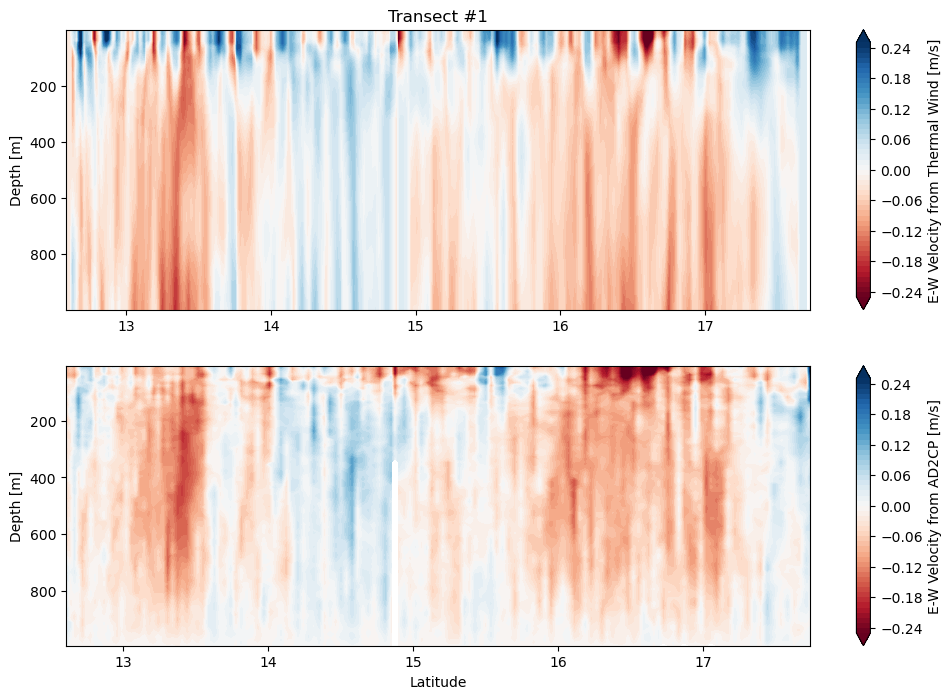

In [28]:
fig, ax = plt.subplots(2,1, figsize=(12, 8))

im1 = ax[0].contourf(transect1_glider.latitude,transect1_glider.depth,transect1_glider.geostrophic_velocity,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[0].invert_yaxis()
fig.colorbar(im1, ax=ax[0],label='E-W Velocity from Thermal Wind [m/s]')
ax[0].set_title('Transect #1')
ax[0].set_ylabel('Depth [m]')

im2 = ax[1].contourf(transect1_ad2cp.latitude,transect1_ad2cp.depth,transect1_ad2cp.u_grid,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[1].invert_yaxis()
fig.colorbar(im2, ax=ax[1],label='E-W Velocity from AD2CP [m/s]')
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Latitude')




Text(0.5, 0, 'Latitude')

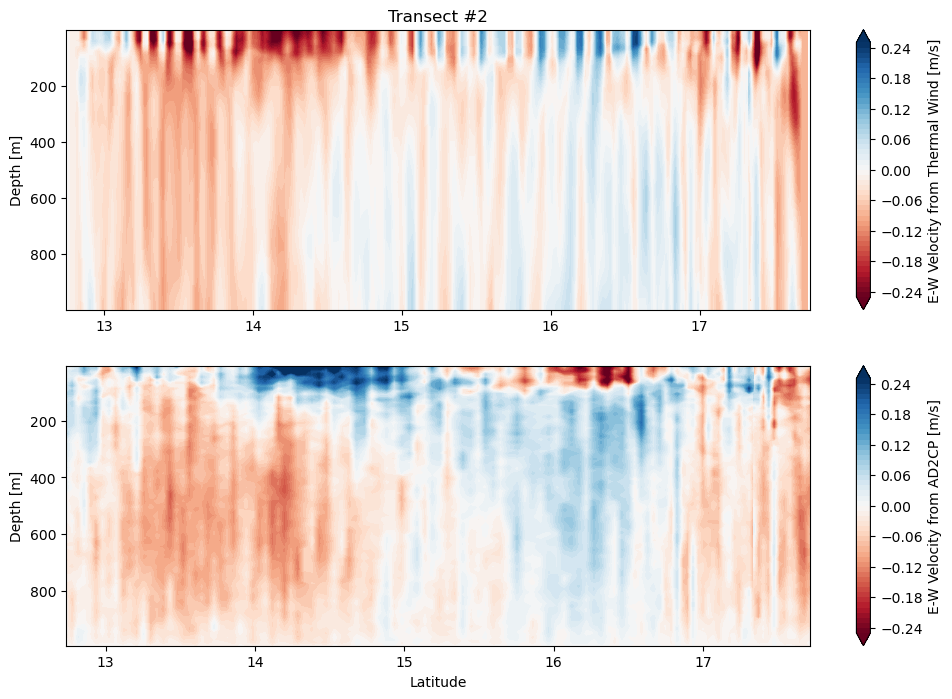

In [29]:
fig, ax = plt.subplots(2,1, figsize=(12, 8))

im1 = ax[0].contourf(transect2_glider.latitude,transect2_glider.depth,transect2_glider.geostrophic_velocity,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[0].invert_yaxis()
fig.colorbar(im1, ax=ax[0],label='E-W Velocity from Thermal Wind [m/s]')
ax[0].set_title('Transect #2')
ax[0].set_ylabel('Depth [m]')

im2 = ax[1].contourf(transect2_ad2cp.latitude,transect2_ad2cp.depth,transect2_ad2cp.u_grid,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[1].invert_yaxis()
fig.colorbar(im2, ax=ax[1],label='E-W Velocity from AD2CP [m/s]')
ax[1].set_ylabel('Depth [m]')
ax[1].set_xlabel('Latitude')




In [30]:
transect1_ad2cp = calc_segment_transport(transect1_ad2cp)
transect2_ad2cp = calc_segment_transport(transect2_ad2cp)

transect1_glider = calc_segment_geostrophic_transport(transect1_glider)
transect2_glider = calc_segment_geostrophic_transport(transect2_glider)


In [31]:
print('Transect #1 Geostrophic Transport',np.nansum(transect1_glider.segment_transport)/(10**6),'Sv')
print('Transect #1 ADCP Transport',np.nansum(transect1_ad2cp.segment_transport)/(10**6),'Sv')
print('Transect #2 Geostrophic Transport',np.nansum(transect2_glider.segment_transport)/(10**6),'Sv')
print('Transect #2 ADCP Transport',np.nansum(transect2_ad2cp.segment_transport)/(10**6),'Sv')


Transect #1 Geostrophic Transport -13.919473503307305 Sv
Transect #1 ADCP Transport -17.63937929556431 Sv
Transect #2 Geostrophic Transport -17.01047404312852 Sv
Transect #2 ADCP Transport -8.977908377668813 Sv


## Compare ADCP velocity and geostrophic velocity

Interp geo onto adcp grid

In [32]:
transect1_glider_interp = transect1_glider.interp(
    {coord: transect1_ad2cp[coord] for coord in transect1_ad2cp.coords if coord in transect1_glider.coords}
)

transect2_glider_interp = transect2_glider.interp(
    {coord: transect2_ad2cp[coord] for coord in transect2_ad2cp.coords if coord in transect2_glider.coords}
)



# Create a boolean mask where latitude is not NaN
mask = ~np.isnan(transect1_glider_interp['latitude'].values)
# Apply the mask to all variables in the dataset
transect1_glider_interp = transect1_glider_interp.isel(time=mask)



# Create a boolean mask where latitude is not NaN
mask = ~np.isnan(transect2_glider_interp['latitude'].values)
# Apply the mask to all variables in the dataset
transect2_glider_interp = transect2_glider_interp.isel(time=mask)



In [33]:
transect1_glider_interp['ageostrophic_velocity'] = transect1_ad2cp.u_grid-transect1_glider_interp.geostrophic_velocity
transect2_glider_interp['ageostrophic_velocity'] = transect2_ad2cp.u_grid-transect2_glider_interp.geostrophic_velocity


Text(0.5, 0, 'Latitude')

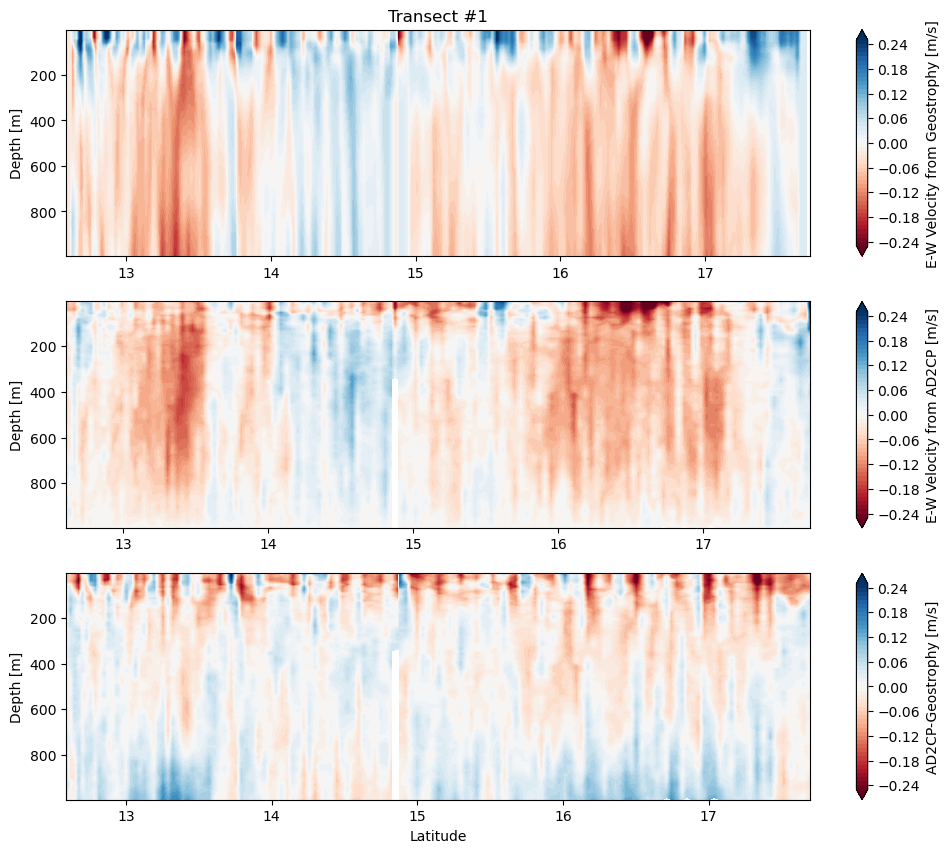

In [34]:
fig, ax = plt.subplots(3,1, figsize=(12, 10))

im1 = ax[0].contourf(transect1_glider.latitude,transect1_glider.depth,transect1_glider.geostrophic_velocity,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[0].invert_yaxis()
fig.colorbar(im1, ax=ax[0],label='E-W Velocity from Geostrophy [m/s]')
ax[0].set_title('Transect #1')
ax[0].set_ylabel('Depth [m]')

im2 = ax[1].contourf(transect1_ad2cp.latitude,transect1_ad2cp.depth,transect1_ad2cp.u_grid,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[1].invert_yaxis()
fig.colorbar(im2, ax=ax[1],label='E-W Velocity from AD2CP [m/s]')
ax[1].set_ylabel('Depth [m]')


im3 = ax[2].contourf(transect1_glider_interp.latitude,transect1_glider_interp.depth,transect1_glider_interp.ageostrophic_velocity,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[2].invert_yaxis()
fig.colorbar(im3, ax=ax[2],label='AD2CP-Geostrophy [m/s]')
ax[2].set_ylabel('Depth [m]')
ax[2].set_xlabel('Latitude')



Text(0.5, 0, 'Latitude')

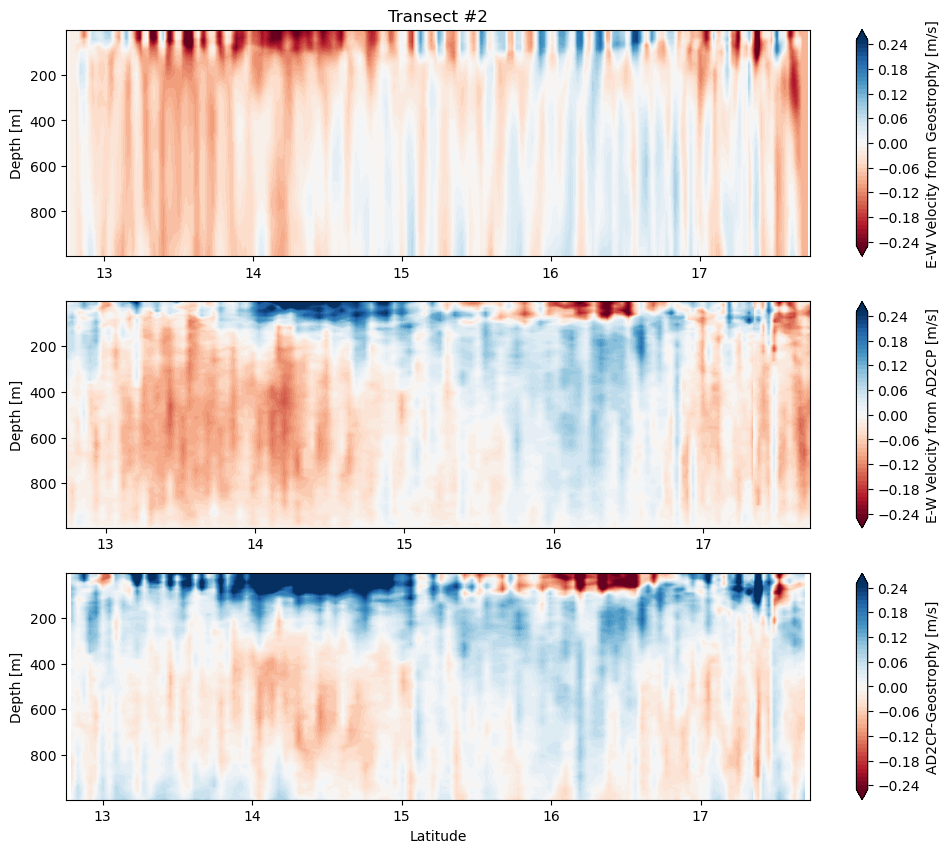

In [35]:
fig, ax = plt.subplots(3,1, figsize=(12, 10))

im1 = ax[0].contourf(transect2_glider.latitude,transect2_glider.depth,transect2_glider.geostrophic_velocity,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[0].invert_yaxis()
fig.colorbar(im1, ax=ax[0],label='E-W Velocity from Geostrophy [m/s]')
ax[0].set_title('Transect #2')
ax[0].set_ylabel('Depth [m]')

im2 = ax[1].contourf(transect2_ad2cp.latitude,transect2_ad2cp.depth,transect2_ad2cp.u_grid,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[1].invert_yaxis()
fig.colorbar(im2, ax=ax[1],label='E-W Velocity from AD2CP [m/s]')
ax[1].set_ylabel('Depth [m]')


im3 = ax[2].contourf(transect2_glider_interp.latitude,transect2_glider_interp.depth,transect2_glider_interp.ageostrophic_velocity,cmap='RdBu',levels=np.arange(-0.25,0.251,0.01),extend='both')
ax[2].invert_yaxis()
fig.colorbar(im3, ax=ax[2],label='AD2CP-Geostrophy [m/s]')
ax[2].set_ylabel('Depth [m]')
ax[2].set_xlabel('Latitude')



In [36]:
transect1_glider_interp = calc_segment_ageostrophic_transport(transect1_glider_interp)
transect2_glider_interp = calc_segment_ageostrophic_transport(transect2_glider_interp)

In [37]:
print('Transect #1 Geostrophic Transport',np.nansum(transect1_glider.segment_transport)/(10**6),'Sv')
print('Transect #1 ADCP Transport',np.nansum(transect1_ad2cp.segment_transport)/(10**6),'Sv')
print('Transect #2 Geostrophic Transport',np.nansum(transect2_glider.segment_transport)/(10**6),'Sv')
print('Transect #2 ADCP Transport',np.nansum(transect2_ad2cp.segment_transport)/(10**6),'Sv')


print('Transect #1 Ageostrophic Transport',np.nansum(transect1_glider_interp.segment_ageo_transport)/(10**6),'Sv')
print('Transect #2 Ageostrophic Transport',np.nansum(transect2_glider_interp.segment_ageo_transport)/(10**6),'Sv')


Transect #1 Geostrophic Transport -13.919473503307305 Sv
Transect #1 ADCP Transport -17.63937929556431 Sv
Transect #2 Geostrophic Transport -17.01047404312852 Sv
Transect #2 ADCP Transport -8.977908377668813 Sv
Transect #1 Ageostrophic Transport -1.9083107635166405 Sv
Transect #2 Ageostrophic Transport 4.058403697015178 Sv


## Rossby Number

In [38]:

def compute_rossby_number(ds):
    """
    Compute the Rossby number from zonal velocity data in an xarray Dataset.
    
    Parameters:
        ds (xarray.Dataset): Input dataset with zonal velocity, latitude, and longitude.

    Returns:
        xarray.Dataset: Original dataset with 'rossby_number' variable added.
    """
    if 'u_grid' in ds:
        u = ds['u_grid']
    elif 'geostrophic_velocity' in ds:
        u = ds['geostrophic_velocity']
    else: print('No velocity data')


    lat = ds['latitude']
    lon = ds['longitude']
    omega = 7.2921e-5
    n_time = ds.dims['time']
    n_depth = ds.dims['depth']
    
    Ro = np.full((n_depth, n_time), np.nan)

    for i in range(1, n_time - 1):
        # Distance between previous and next point (centered diff)
        p1 = (float(lat[i - 1]), float(lon[i - 1]))
        p2 = (float(lat[i + 1]), float(lon[i + 1]))
        dy = geodesic(p1, p2).meters

        # Coriolis at midpoint latitude
        lat_mid = (lat[i - 1] + lat[i + 1]) / 2
        f = 2 * omega * np.sin(np.deg2rad(lat_mid))

        du = u[:,i+1]-u[:,i-1]
        dudy = du/dy
        Ro[:,i] = np.abs(dudy/f)

    ds['rossby_number'] = (('depth','time'), Ro)

    return ds


transect1_ad2cp = compute_rossby_number(transect1_ad2cp)
transect2_ad2cp = compute_rossby_number(transect2_ad2cp)


transect1_glider = compute_rossby_number(transect1_glider)
transect2_glider = compute_rossby_number(transect2_glider)


/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46424/1357550743.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_time = ds.dims['time']
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46424/1357550743.py:22: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_depth = ds.dims['depth']
/var/folders/m9/d8bbz1wx4f50q99kfb1jv9pw0000gn/T/ipykernel_46424/1357550743.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension nam

## I like this plot:

Shows the mean Rossby number is >0.1 down to a deeper depth. So, enhanced mesoscale features rather than being driven by large-scale flow (Ro<<1). This could be an explanation for why there is less transport, the eddies!

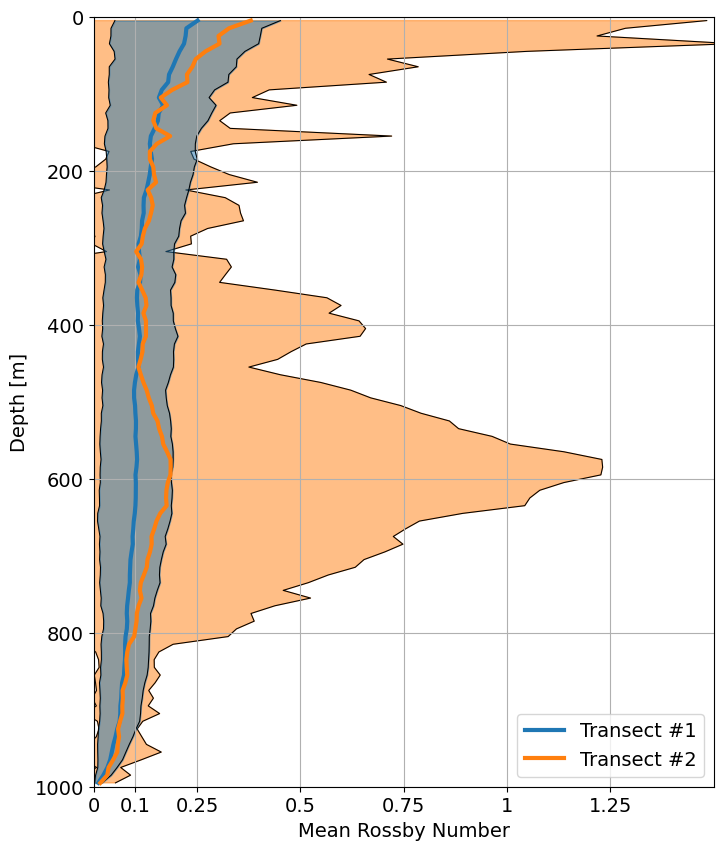

In [44]:
transect1_adcp_Ro_mean = transect1_ad2cp.rossby_number.mean(dim='time')
transect1_adcp_Ro_std = transect1_ad2cp.rossby_number.std(dim='time')
transect2_adcp_Ro_mean = transect2_ad2cp.rossby_number.mean(dim='time')
transect2_adcp_Ro_std = transect2_ad2cp.rossby_number.std(dim='time')


font_size = 14

plt.figure(figsize=(8,10))
plt.plot(transect1_adcp_Ro_mean,transect1_ad2cp.depth,linewidth=3,label='Transect #1',color='tab:blue',zorder=2)
plt.fill_betweenx(transect1_ad2cp.depth,transect1_adcp_Ro_mean-transect1_adcp_Ro_std,transect1_adcp_Ro_mean+transect1_adcp_Ro_std,color='tab:blue',alpha=0.5,zorder=1)
plt.plot(transect1_adcp_Ro_mean-transect1_adcp_Ro_std,transect1_ad2cp.depth,linewidth=0.75,color='black',zorder=1)
plt.plot(transect1_adcp_Ro_mean+transect1_adcp_Ro_std,transect1_ad2cp.depth,linewidth=0.75,color='black',zorder=1)


plt.plot(transect2_adcp_Ro_mean,transect2_ad2cp.depth,linewidth=3,label='Transect #2',color='tab:orange',zorder=2)
plt.fill_betweenx(transect2_ad2cp.depth,transect2_adcp_Ro_mean-transect2_adcp_Ro_std,transect2_adcp_Ro_mean+transect2_adcp_Ro_std,color='tab:orange',alpha=0.5,zorder=0)
plt.plot(transect2_adcp_Ro_mean-transect2_adcp_Ro_std,transect2_ad2cp.depth,linewidth=0.75,color='black',zorder=0)
plt.plot(transect2_adcp_Ro_mean+transect2_adcp_Ro_std,transect2_ad2cp.depth,linewidth=0.75,color='black',zorder=0)

#plt.axvline(x=0.1, color='black', linestyle='--', linewidth=1,zorder=0)


plt.ylim(1000,0)
plt.xlabel('Mean Rossby Number',fontsize=font_size)
plt.ylabel('Depth [m]',fontsize=font_size)

plt.legend(fontsize=font_size)
plt.xticks(ticks=[0,0.1,0.25,0.5,0.75,1,1.25], labels=[0,0.1,0.25,0.5,0.75,1,1.25])
plt.grid()
plt.xlim(0,1.5)

plt.gca().tick_params(axis='both', which='major', labelsize=font_size)


plt.savefig('../figures/RU29_2024_ABC2DR_Mean_Rossby_Profiles_per_Transect.png',bbox_inches='tight',dpi=300,facecolor='white')

